Import libraries:

In [204]:
import warnings
warnings.filterwarnings('ignore')
from nltk import tokenize

from networkx.algorithms.centrality import betweenness_centrality
from nltk.stem.wordnet import WordNetLemmatizer
from googlesearch import search 

from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib.request
import concurrent.futures
from tqdm import tqdm

import itertools
import collections
import winsound

from nltk.corpus import stopwords 
from heapq import nlargest

import urllib
import requests
import time
import random

import re
import logging
import numpy as np
import pandas as pd
import nltk

from requests import get
from pattern.web import plaintext
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.cluster.util import cosine_distance

import networkx as nx
from collections import OrderedDict
import trkeyword

Disable logging:

In [205]:
import logging, sys
logging.disable(sys.maxsize)

Load vocabularies:

In [206]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\skamenshchikov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\skamenshchikov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

CDFs:

In [207]:
def tags(x):
    return nltk.pos_tag(nltk.word_tokenize(x))[0][1]

def get_unique_text(document):
    unique_sentences = []
    for sentence in [sent.raw for sent in TextBlob(document).sentences]:
        if sentence not in unique_sentences:
            unique_sentences.append(sentence)
    return ' '.join(unique_sentences)

def text_normalize(txt):
    processed_text = (re.sub('[^a-zA-Z]', ' ', txt)).lower()
    processed_text=re.sub("(\\d|\\W)+"," ",processed_text)

    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(processed_text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stop_words]
    tokens = [i for i in tokens if (tags(i) in ['NN', 'NNP', 'NNS', 'NNPS'])]
    
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)    

def create_graph(text, nodes=25, max_component=False, common=500):
    ## create graph
    bigrams=list(nltk.ngrams(tokens, 2))
    bigram_counts = collections.Counter(bigrams)

    bigram_df = pd.DataFrame(bigram_counts.most_common(common), columns=['bigram', 'count'])
    d = bigram_df.set_index('bigram').T.to_dict('records')

    G = nx.Graph()
    for k, v in d[0].items():
            G.add_edge(k[0], k[1], weight=(v*10))
    ## /create graph

    ## show max connected component
    if max_component==True:
        G = max(connected_component_subgraphs(G), key=len)
        G = nx.dfs_tree(G)
    ## /show max connected component

    ## remove isolates
    G.remove_nodes_from(list(nx.isolates(G)))
    ## /remove isolates

    ## filter graph by degree
    threshold = int(G.number_of_nodes()*(max(nx.degree_centrality(G).values()))) #max centrality, nodes

    for i in range(0, threshold):
        F = nx.Graph() # empty graph
        fedges = filter(lambda x: G.degree()[x[0]] > 0 and G.degree()[x[1]] > i, G.edges())
        F.add_edges_from(fedges)
        F.remove_nodes_from(list(nx.isolates(F)))

        if F.number_of_nodes() < nodes:
            break
    ## /filter graph by degree

    pos = nx.spring_layout(F, iterations=500)
    # pos = nx.nx_agraph.graphviz_layout(F)

    return F, pos

Parse text from some web page:

In [208]:
htmlString = get('https://medium.com/@sergeykamenshchikov/nlp-for-composition-of-value-tree-d8495534ebd5')
soup = BeautifulSoup(htmlString.content, 'html5lib')
paragraphs = soup.find_all(['p', 'article', 'section', 'title', 'h1', 'h2', 'h3'])
rawtext = get_unique_text(' '.join([i.text for i in paragraphs]))

Draw graph:

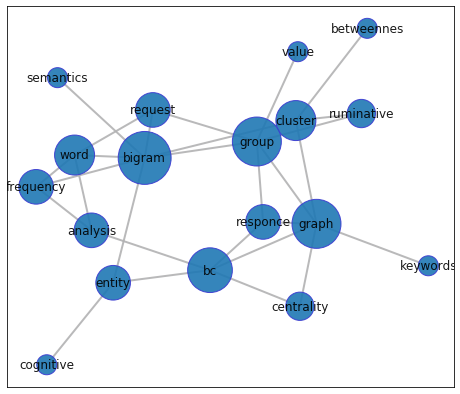

In [209]:
F,pos = create_graph(rawtext)
d = dict(F.degree)
fig = plt.figure(figsize=(8,7))

nx.draw_networkx(F, font_size=12, width=2, alpha=0.9, with_labels = True, edgecolors='#3A3AD1', 
                 node_size=[v * 400 for v in d.values()], font_color='black', arrows=False, edge_color='#B2B2B3')
plt.show()